<a href="https://colab.research.google.com/github/kanakesh2006/Langgraph_for_Agentic_AI_Concepts/blob/main/Parallel%20Workflows/batsman_parallel_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Parallel Workflows/

In [1]:
!pip install langchain langgraph langchain_google_genai langchain_community transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.1/719.1 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.9/234.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.43.0
    Uninstalling google-auth-2.43.0:
      Successfully uninstalled google-auth-2.43.0
  Attempting uninstall: google-g

In [2]:
import os
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
os.environ['HUGGINGFACE_API_KEY'] = userdata.get('HUGGINGFACE_API_KEY')


In [3]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [4]:
from langchain_community.llms import HuggingFacePipeline
from transformers import pipeline

pipe = pipeline(
    "text-generation",
    model="TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    max_new_tokens=512,
    return_full_text=False
)

model = HuggingFacePipeline(pipeline=pipe)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Device set to use cpu
/tmp/ipython-input-916791060.py:11: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFacePipeline``.
  model = HuggingFacePipeline(pipeline=pipe)


In [5]:
# define state

class BatsmanState(TypedDict):

  runs: int
  balls: int
  fours: int
  sixes: int

  sr: float
  bpb: float
  bp: float

  summary: str

In [6]:
# node functions

def calc_sr(state: BatsmanState):

  sr = ( state['runs'] / state['balls'] ) * 100

  return {'sr': sr}


def calc_bpb(state: BatsmanState):

  bpb = state['balls'] / ( state['fours'] + state['sixes'] )

  return {'bpb': bpb}


def calc_bp(state: BatsmanState):

  bp = (  ( (state['fours'] * 4) + (state['sixes'] * 6) ) / state['runs']  ) * 100

  return {'bp': bp}


def Summary(state: BatsmanState):

  summary = f"""
  Strike Rate: {state['sr']} \n
  Balls Per Boundary: {state['bpb']} \n
  Boundary Percent: {state['bp']} \n
  """

  return {'summary': summary}



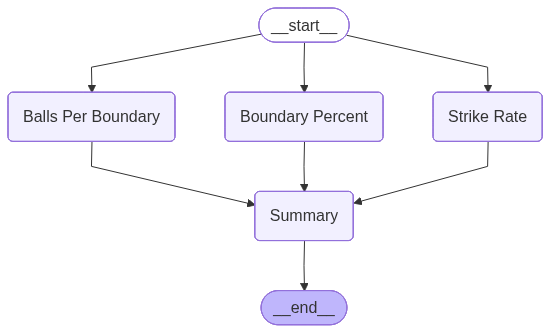

In [7]:
# define graph
graph = StateGraph(BatsmanState)

# add nodes
graph.add_node('Strike Rate', calc_sr)
graph.add_node('Balls Per Boundary', calc_bpb)
graph.add_node('Boundary Percent', calc_bp)
graph.add_node('Summary', Summary)

# add edges
graph.add_edge(START, 'Strike Rate')
graph.add_edge(START, 'Balls Per Boundary')
graph.add_edge(START, 'Boundary Percent')

graph.add_edge('Strike Rate', 'Summary')
graph.add_edge('Balls Per Boundary', 'Summary')
graph.add_edge('Boundary Percent', 'Summary')

graph.add_edge('Summary', END)


# compile graph
graph.compile()

In [8]:
workflow = graph.compile()

initial_state = {
    'runs': 100,
    'balls': 50,
    'fours': 6,
    'sixes': 4
}

final_state = workflow.invoke(initial_state)

print(final_state)

{'runs': 100, 'balls': 50, 'fours': 6, 'sixes': 4, 'sr': 200.0, 'bpb': 5.0, 'bp': 48.0, 'summary': '\n  Strike Rate: 200.0 \n\n  Balls Per Boundary: 5.0 \n\n  Boundary Percent: 48.0 \n\n  '}


In [9]:
print(final_state['summary'])


  Strike Rate: 200.0 

  Balls Per Boundary: 5.0 

  Boundary Percent: 48.0 

  
